In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

import torch
import matplotlib.pyplot as plt
from src import models, data
from tqdm.auto import tqdm
import json
import os
import numpy as np
import copy

os.makedirs("layer_sweep/Jacobian_plots", exist_ok=True)
os.makedirs("layer_sweep/weights_and_biases", exist_ok=True)

In [3]:
# from transformers import AutoTokenizer, AutoModelForCausalLM

# tokenizer = AutoTokenizer.from_pretrained("gpt2")
# model = AutoModelForCausalLM.from_pretrained("gpt2")

In [4]:
device = "cuda:0"
mt = models.load_model("gptj", device=device)
print(
    f"dtype: {mt.model.dtype}, device: {mt.model.device}, memory: {mt.model.get_memory_footprint()}"
)

dtype: torch.float16, device: cuda:0, memory: 12219206136


In [5]:
dataset = data.load_dataset()
cur_relation =[d for d in dataset if d.name == "country capital city"][0]
print(cur_relation)
# capital_cities.__dict__.keys()
len(cur_relation.samples)

Relation(name='country capital city', prompt_templates=['The capital city of {} is', 'The political capital of {} is', 'The seat of government for {} is', 'The government of {} is centered in'], samples=[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='Canada', object='Ottawa'), RelationSample(subject='Mexico', object='Mexico City'), RelationSample(subject='Brazil', object='Bras\\u00edlia'), RelationSample(subject='Argentina', object='Buenos Aires'), RelationSample(subject='Chile', object='Santiago'), RelationSample(subject='Peru', object='Lima'), RelationSample(subject='Colombia', object='Bogot\\u00e1'), RelationSample(subject='Venezuela', object='Caracas'), RelationSample(subject='Spain', object='Madrid'), RelationSample(subject='France', object='Paris'), RelationSample(subject='Germany', object='Berlin'), RelationSample(subject='Italy', object='Rome'), RelationSample(subject='Russia', object='Moscow'), RelationSample(subject='China', object=

24

In [10]:
from h_param_sweep.utils import select_subset_from_relation

training_set = select_subset_from_relation(relation=cur_relation, n=3)
training_set.samples

[RelationSample(subject='Saudi Arabia', object='Riyadh'),
 RelationSample(subject='Colombia', object='Bogot\\u00e1'),
 RelationSample(subject='Mexico', object='Mexico City')]

In [11]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=24,
    bias_scale_factor=0.4       # so that the bias doesn't knock out the prediction too much in the direction of training examples
) 

operator = mean_estimator(training_set)
operator("United States", k = 10).predictions

[PredictedToken(token='Washington', prob=0.3533760905265808),
 PredictedToken(token='Mexico', prob=0.06904236972332001),
 PredictedToken(token='the', prob=0.047824252396821976),
 PredictedToken(token='located', prob=0.04155043140053749),
 PredictedToken(token='\n', prob=0.030162379145622253),
 PredictedToken(token='R', prob=0.0274631567299366),
 PredictedToken(token='Bog', prob=0.02661820687353611),
 PredictedToken(token='also', prob=0.01993611641228199),
 PredictedToken(token=',', prob=0.019474295899271965),
 PredictedToken(token='known', prob=0.01678789220750332)]

In [12]:
from src.data import RelationDataset
from src.benchmarks import faithfulness

In [13]:
mt.tokenizer.pad_token = "</s>"
mt.tokenizer.pad_token_id = 2

In [14]:
faith_result = faithfulness(
    estimator=mean_estimator,
    dataset = RelationDataset([cur_relation]),
    n_train=3,
    n_trials=5,
    k=3
)

faithfulness:   0%|          | 0/1 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [16]:
faith_result.metrics.__dict__

{'recall_lm': [0.9714285731315613, 1.0, 1.0],
 'recall_lre': [0.12380953133106232, 0.17142857611179352, 0.22857144474983215],
 'recall_zs': [0.8190476298332214, 0.8952381014823914, 0.9809523820877075],
 'recall_pd': [0.6285714507102966, 0.6761904954910278, 0.7142857313156128],
 'recall_lens': [0.10476191341876984, 0.18095238506793976, 0.2380952388048172],
 'recall_lre_if_lm_correct': [0.12380953133106232,
  0.17142857611179352,
  0.22857144474983215],
 'recall_lre_if_lm_wrong': nan,
 'recall_pd_if_zs_correct': [0.6428571939468384,
  0.691428542137146,
  0.729523777961731],
 'recall_pd_if_zs_wrong': [0.0, 0.0, 0.0],
 'recall_lens_if_zs_correct': [0.10952381044626236,
  0.18761906027793884,
  0.24523809552192688],
 'recall_lens_if_zs_wrong': [0.0, 0.0, 0.0],
 'count_lm_correct': 105,
 'count_lm_wrong': 0,
 'count_zs_correct': 103,
 'count_zs_wrong': 2}

In [19]:
tokenized

{'input_ids': tensor([[    1,   450, 14121, 20768,   280,   338,  5982,   297,   278,  4272,
           310]], device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [20]:
from src.lens import interpret_logits, logit_lens
from src.functional import untuple

prompt = "The Space Needle is located in the city of"
tokenized = mt.tokenizer(prompt, return_tensors="pt", padding=True).to(mt.model.device)
tokenized.pop("token_type_ids")

import baukit

with baukit.TraceDict(
    mt.model,
    models.determine_layer_paths(mt)
) as traces:
    output = mt.model(**tokenized)
    
interpret_logits(mt, output.logits[0][-1])

[('Seattle', 17.141),
 ('Se', 12.008),
 ('the', 10.242),
 ('\n', 10.0),
 (',', 9.922),
 ('Belle', 9.82),
 ('dow', 9.656),
 ('Washington', 9.641),
 ('...', 9.539),
 ('my', 9.32)]

In [21]:
interested_words = [" Seattle", " Paris", " Dhaka"]
int_tokenized = mt.tokenizer(interested_words, return_tensors="pt", padding=True).to(
    mt.model.device
)
int_tokenized.input_ids

z = untuple(traces[models.determine_layer_paths(mt)[-1]].output)[0][-1]
print(z.shape)

logit_lens(mt, z, [t[0] for t in int_tokenized.input_ids], get_proba=False)

torch.Size([5120])


([('Seattle', 17.141),
  ('Se', 12.008),
  ('the', 10.242),
  ('\n', 10.0),
  (',', 9.922),
  ('Belle', 9.82),
  ('dow', 9.656),
  ('Washington', 9.641),
  ('...', 9.539),
  ('my', 9.32)],
 {tensor(2, device='cuda:0'): (5.125, '</s>'),
  tensor(2, device='cuda:0'): (5.125, '</s>'),
  tensor(1, device='cuda:0'): (-10.7578125, '<s>')})

In [22]:
from src.functional import predict_next_token

predict_next_token(
    mt = mt, prompt = "The Space Needle is located in the city of", k=10
)

[[PredictedToken(token='Seattle', prob=0.9726701378822327),
  PredictedToken(token='Se', prob=0.005738698877394199),
  PredictedToken(token='the', prob=0.0009817755781114101),
  PredictedToken(token='\n', prob=0.00077060452895239),
  PredictedToken(token=',', prob=0.0007126926793716848),
  PredictedToken(token='Belle', prob=0.0006438641576096416),
  PredictedToken(token='dow', prob=0.0005464404821395874),
  PredictedToken(token='Washington', prob=0.0005379686481319368),
  PredictedToken(token='...', prob=0.00048601420712657273),
  PredictedToken(token='my', prob=0.0003905233752448112)]]

In [23]:
from h_param_sweep.utils import filter_by_model_knowledge

In [24]:
import numpy as np
from src.functional import make_prompt

icl_indices = np.random.choice(range(len(cur_relation.samples)), 3, replace=False)
icl_samples = [cur_relation.samples[i] for i in icl_indices]

icl_prompt = make_prompt(
    prompt_template = cur_relation.prompt_templates[0],
    subject="{}",
    examples=icl_samples,
)

print(icl_prompt)

The capital city of Russia is Moscow
The capital city of Venezuela is Caracas
The capital city of Mexico is Mexico City
The capital city of {} is


In [25]:
model_knows = filter_by_model_knowledge(mt, icl_prompt, cur_relation.samples)
len(model_knows)

23

## Layer Richness based on logit lens

In [26]:
from src.lens import layer_c_measure

# relation_prompt = mt.tokenizer.eos_token + " {} is located in the city of"
# subject = "The Space Needle"
# layer_c_measure(mt, relation_prompt, subject, measure = "contribution", verbose=True)

  0%|          | 0/23 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from '/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

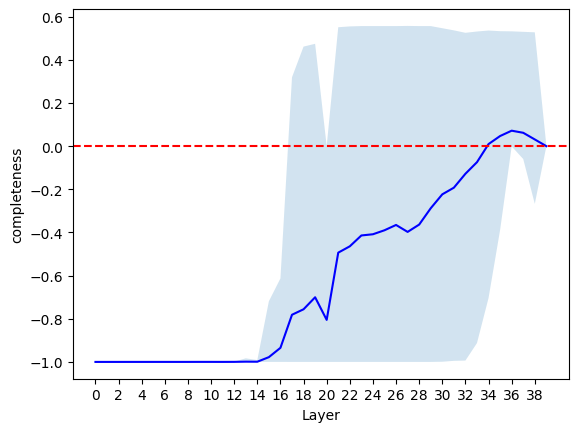

In [28]:
from h_param_sweep.plotting import plot_c_measure

c_measure = {layer: [] for layer in models.determine_layer_paths(mt)}

for sample in tqdm(model_knows):
    cur_richness = layer_c_measure(mt, icl_prompt, sample.subject)
    for layer in models.determine_layer_paths(mt):
        c_measure[layer].append(cur_richness[layer])
plot_c_measure(c_measure, measure="completeness")

  0%|          | 0/23 [00:00<?, ?it/s]

<module 'matplotlib.pyplot' from '/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

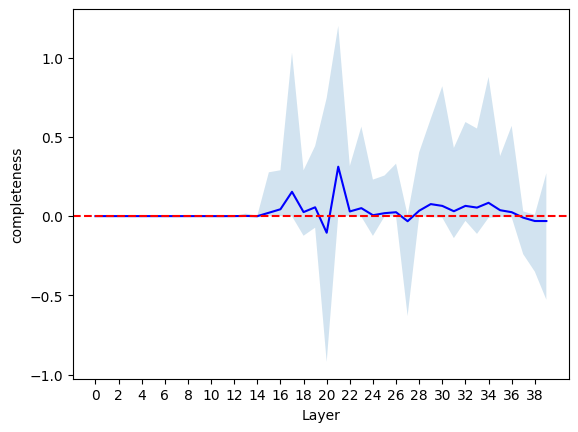

In [29]:
c_measure = {layer: [] for layer in models.determine_layer_paths(mt)}

for sample in tqdm(model_knows):
    cur_richness = layer_c_measure(mt, icl_prompt, sample.subject, measure="contribution")
    for layer in models.determine_layer_paths(mt):
        c_measure[layer].append(cur_richness[layer])
plot_c_measure(c_measure, measure="completeness")

## Layer Richness based on `Jh_norm` and `J_norm`

In [ ]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [ ]:
from src.operators import JacobianEstimator, JacobianIclMeanEstimator
from src.data import RelationSample

# indices = np.random.choice(range(len(capital_cities.samples)), 3, replace=False)
# samples = [capital_cities.samples[i] for i in indices]

# training_samples = copy.deepcopy(capital_cities.__dict__)
# training_samples["samples"] = samples
# training_samples = data.Relation(**training_samples)

# mean_estimator = JacobianIclMeanEstimator(
#     mt=mt,
#     h_layer=12,
# )

# operator = mean_estimator(training_samples)
# operator("Russia", k = 10).predictions

In [ ]:
estimator = JacobianEstimator(
    mt=mt,
    h_layer=12,
)

operator = estimator.estimate_for_subject(
    subject = "United States",
    prompt_template= icl_prompt
)

In [ ]:
operator.metadata['Jh'].norm().item(), operator.weight.norm().item()

In [ ]:
layerwise_jh = {layer: [] for layer in models.determine_layer_paths(mt)}

for sample in tqdm(set(model_knows) - set(icl_samples)):
    for h_layer in range(0, 24):
        layer_name = models.determine_layer_paths(mt)[h_layer]
        estimator = JacobianEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = estimator.estimate_for_subject(
            # subject = "Russia",
            subject = sample.subject,
            prompt_template= icl_prompt
        )

        # print(h_layer, " ===> ", f"J:{operator.weight.norm().item()},  Jh: {operator.misc['Jh'].norm().item()}")
        layerwise_jh[layer_name].append({
            "J": operator.weight.norm().item(),
            "Jh": operator.metadata['Jh'].norm().item(),
            "bias": operator.bias.norm().item()
        })

In [ ]:
for layer in models.determine_layer_paths(mt):
    if layer in layerwise_jh and len(layerwise_jh[layer]) == 0:
        layerwise_jh.pop(layer)

with open("layer_sweep/layer_jh_info.json", "w") as f:
    json.dump(layerwise_jh, f)

In [ ]:
key = "Jh"

info = {
    layer: np.array([layerwise_jh[layer][i][key] for i in range(len(layerwise_jh[layer]))])
    for layer in layerwise_jh.keys()
}

mean = [info[layer].mean() for layer in info.keys()]
plt.plot(mean, color="blue", linewidth=4)
plt.xticks(range(0, len(mean), 2))
plt.ylabel(f"{key}_norm")

for i in range(len(set(model_knows) - set(icl_samples))):
    arr = []
    for layer in layerwise_jh.keys():
        arr.append(layerwise_jh[layer][i][key])
    plt.plot(arr, alpha=0.2)

plt.show()

## Causal Tracing on `subject_last`

In [30]:
from src.lens import causal_tracing

In [40]:
causal_tracing(
    mt,
    prompt_template = "The location of {} is in the city of",
    subject_original = "The Space Needle",
    subject_corruption = "The Statue of Liberty",
    # verbose = True
)

{'model.layers.0': -0.9983224255299707,
 'model.layers.1': -0.9981562296549479,
 'model.layers.2': -0.08854166666666664,
 'model.layers.3': -0.09196820175438594,
 'model.layers.4': -0.08283077485380115,
 'model.layers.5': -0.06455592105263155,
 'model.layers.6': -0.05142086988304092,
 'model.layers.7': -0.06798245614035085,
 'model.layers.8': -0.08739948830409355,
 'model.layers.9': -0.0811175073099415,
 'model.layers.10': -0.0834018640350877,
 'model.layers.11': -0.12680464181286547,
 'model.layers.12': -0.16963633040935672,
 'model.layers.13': -0.22731633771929824,
 'model.layers.14': -0.282140899122807,
 'model.layers.15': -0.3495294225146199,
 'model.layers.16': -0.6265076754385965,
 'model.layers.17': -0.749149077119883,
 'model.layers.18': -0.9457465277777778,
 'model.layers.19': -0.9580249451754386,
 'model.layers.20': -0.9624508863304093,
 'model.layers.21': -0.9926829198647661,
 'model.layers.22': -0.9942980314555921,
 'model.layers.23': -0.9976397954929642,
 'model.layers.24'

In [41]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [42]:
num_icl = 3

icl_indices = np.random.choice(range(len(cur_relation_known.samples)), num_icl, replace=False)
icl_samples = [cur_relation.samples[i] for i in icl_indices]
icl_prompt = [
    f"{cur_relation.prompt_templates[0].format(sample.subject)} {sample.object}"
    for sample in icl_samples
]
icl_prompt = "\n".join(icl_prompt) + "\n" + cur_relation.prompt_templates[0]

print(icl_prompt)

The capital city of Turkey is Ankara
The capital city of Peru is Lima
The capital city of France is Paris
The capital city of {} is


In [43]:
test_samples = set(cur_relation_known.samples) - set(icl_samples)
causal_tracing_results = {layer: [] for layer in models.determine_layer_paths(mt)}

n_runs = 20
for run in tqdm(range(n_runs)):
    sample_pair = np.random.choice(range(len(test_samples)), 2, replace=False)
    sample_pair = [list(test_samples)[i] for i in sample_pair]
    print(sample_pair)
    
    cur_result = causal_tracing(
        mt,
        prompt_template = icl_prompt,
        subject_original = sample_pair[0].subject,
        subject_corruption = sample_pair[1].subject,
    )

    for layer in models.determine_layer_paths(mt):
        causal_tracing_results[layer].append(cur_result[layer])

  0%|          | 0/20 [00:00<?, ?it/s]

[RelationSample(subject='Russia', object='Moscow'), RelationSample(subject='Argentina', object='Buenos Aires')]
[RelationSample(subject='Saudi Arabia', object='Riyadh'), RelationSample(subject='Argentina', object='Buenos Aires')]
[RelationSample(subject='Russia', object='Moscow'), RelationSample(subject='Australia', object='Canberra')]
[RelationSample(subject='Venezuela', object='Caracas'), RelationSample(subject='India', object='New Delhi')]
[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='Italy', object='Rome')]
[RelationSample(subject='Mexico', object='Mexico City'), RelationSample(subject='Argentina', object='Buenos Aires')]
[RelationSample(subject='Chile', object='Santiago'), RelationSample(subject='Spain', object='Madrid')]
[RelationSample(subject='Saudi Arabia', object='Riyadh'), RelationSample(subject='Venezuela', object='Caracas')]
[RelationSample(subject='South Korea', object='Seoul'), RelationSample(subject='China', object='Beijing'

<module 'matplotlib.pyplot' from '/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/matplotlib/pyplot.py'>

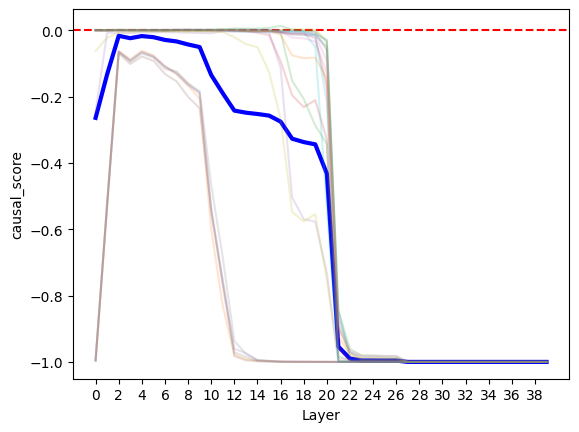

In [44]:
from h_param_sweep.plotting import plot_layer_wise_causal_tracing

plot_layer_wise_causal_tracing(causal_tracing_results)

## Layer sweep on mean ICL

In [45]:
import copy

cur_relation_known = copy.deepcopy(cur_relation.__dict__)
cur_relation_known["samples"] = model_knows

cur_relation_known = data.Relation(**cur_relation_known)

In [46]:
indices = np.random.choice(range(len(cur_relation_known.samples)), 2, replace=False)
samples = [cur_relation_known.samples[i] for i in indices]

capital_cities_subset = copy.deepcopy(cur_relation.__dict__)
capital_cities_subset["samples"] = samples
capital_cities_subset = data.Relation(**capital_cities_subset)

len(capital_cities_subset.samples)

2

In [47]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=12,
)

operator = mean_estimator(capital_cities_subset)

In [48]:
operator("Chile", k = 10).predictions

[PredictedToken(token='Santiago', prob=0.7633925676345825),
 PredictedToken(token='Lima', prob=0.08836910873651505),
 PredictedToken(token='the', prob=0.016604062169790268),
 PredictedToken(token='Car', prob=0.013982023112475872),
 PredictedToken(token='also', prob=0.009914739057421684),
 PredictedToken(token='in', prob=0.006814293563365936),
 PredictedToken(token='La', prob=0.006656440906226635),
 PredictedToken(token='\n', prob=0.006302191410213709),
 PredictedToken(token='Chile', prob=0.004869956057518721),
 PredictedToken(token='called', prob=0.004399639088660479)]

In [49]:
predictions = []
target = []

for sample in tqdm(set(cur_relation_known.samples)):
    cur_predictions = operator(sample.subject, k = 5).predictions
    predictions.append([
        p.token for p in cur_predictions
    ])
    target.append(sample.object)

  0%|          | 0/23 [00:00<?, ?it/s]

In [50]:
from src.metrics import recall

recall(predictions, target)

[0.30434782608695654,
 0.43478260869565216,
 0.4782608695652174,
 0.5652173913043478,
 0.5652173913043478]

In [51]:
# np.savez("layer_sweep/operator_weight.npz", jacobian = operator.weight.detach().cpu().numpy(), allow_pickle=True)

In [52]:
# j = np.load("layer_sweep/operator_weight.npz", allow_pickle=True)["jacobian"]

In [53]:
# torch.dist(torch.tensor(j).to(device), operator.weight)

In [54]:
def get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True):

    layer_wise_recall = {}

    layer_names = models.determine_layer_paths(mt)
    for h_layer, layer_name in tqdm(list(enumerate(layer_names))[::2]):
        mean_estimator = JacobianIclMeanEstimator(
            mt=mt,
            h_layer=h_layer,
        )
        operator = mean_estimator(capital_cities_subset)
        if(save_weights):
            np.savez(
                f"layer_sweep/weights_and_biases/{layer_name}.npz", 
                jacobian = operator.weight.detach().cpu().numpy(),
                bias = operator.bias.detach().cpu().numpy(), 
                allow_pickle=True
            )

        predictions = []
        target = []

        for sample in set(cur_relation_known.samples) - set(capital_cities_subset.samples):
            cur_predictions = operator(sample.subject, k = 5).predictions
            predictions.append([
                p.token for p in cur_predictions
            ])
            target.append(sample.object)

        layer_wise_recall[layer_name] = recall(predictions, target)
        
        if(verbose):
            print(layer_name, layer_wise_recall[layer_name])
    
    return layer_wise_recall

layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose = True, save_weights = True)

  0%|          | 0/20 [00:00<?, ?it/s]

model.layers.0 [0.0, 0.0, 0.14285714285714285, 0.23809523809523808, 0.23809523809523808]
model.layers.2 [0.09523809523809523, 0.14285714285714285, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857]
model.layers.4 [0.14285714285714285, 0.23809523809523808, 0.2857142857142857, 0.2857142857142857, 0.2857142857142857]
model.layers.6 [0.14285714285714285, 0.23809523809523808, 0.2857142857142857, 0.3333333333333333, 0.38095238095238093]
model.layers.8 [0.19047619047619047, 0.23809523809523808, 0.23809523809523808, 0.2857142857142857, 0.2857142857142857]
model.layers.10 [0.23809523809523808, 0.23809523809523808, 0.2857142857142857, 0.38095238095238093, 0.38095238095238093]
model.layers.12 [0.23809523809523808, 0.38095238095238093, 0.42857142857142855, 0.5238095238095238, 0.5238095238095238]
model.layers.14 [0.2857142857142857, 0.42857142857142855, 0.42857142857142855, 0.5238095238095238, 0.5238095238095238]
model.layers.16 [0.3333333333333333, 0.42857142857142855, 0.42857142857142855

In [55]:
faithfulness_result = {}
number_of_runs = 5

for run in tqdm(range(number_of_runs)):
    indices = np.random.choice(range(len(cur_relation_known.samples)), 2, replace=False)
    samples = [cur_relation_known.samples[i] for i in indices]

    capital_cities_subset = copy.deepcopy(cur_relation.__dict__)
    capital_cities_subset["samples"] = samples
    capital_cities_subset = data.Relation(**capital_cities_subset)

    layer_wise_recall = get_layer_wise_recall(capital_cities_subset, verbose=False, save_weights=False)

    for layer in layer_wise_recall.keys():
        if(layer not in faithfulness_result):
            faithfulness_result[layer] = []
        faithfulness_result[layer].append(layer_wise_recall[layer])

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [56]:
# with open("layer_sweep/layer_wise_recall_collection.json", "w") as f:
#     json.dump(faithfulness_result, f)

# with open("layer_sweep/layer_wise_recall_collection.json") as f:
#     faithfulness_result = json.load(f)

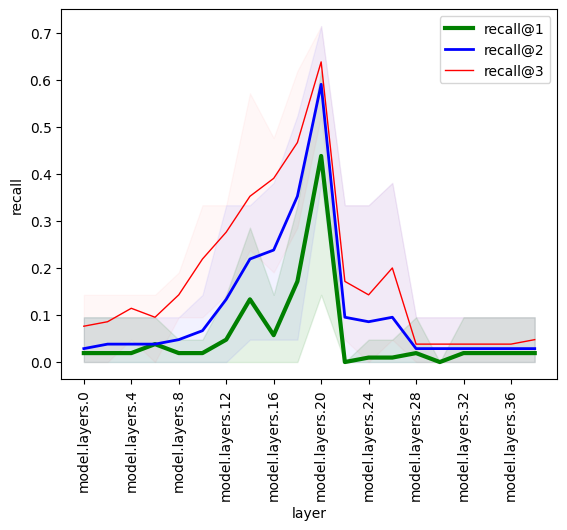

In [57]:
# top_1 = [layer_wise_recall[layer][0] for layer in layer_wise_recall.keys()]
# top_2 = [layer_wise_recall[layer][1] for layer in layer_wise_recall.keys()]
# top_3 = [layer_wise_recall[layer][2] for layer in layer_wise_recall.keys()]

import numpy as np

top_1 = np.array([
    np.array(faithfulness_result[layer])[:, 0]
    for layer in faithfulness_result.keys()
])

top_2 = np.array([
    np.array(faithfulness_result[layer])[:, 1]
    for layer in faithfulness_result.keys()
])

top_3 = np.array([
    np.array(faithfulness_result[layer])[:, 2]
    for layer in faithfulness_result.keys()
])


plt.plot(top_1.mean(axis=1), color="green", linewidth=3, label="recall@1")
plt.plot(top_2.mean(axis=1), color="blue", linewidth=2, label="recall@2")
plt.plot(top_3.mean(axis=1), color="red", linewidth=1, label="recall@3")

plt.fill_between(
    range(len(faithfulness_result.keys())),
    top_1.min(axis=1), top_1.max(axis=1),
    color="green", alpha=0.1
)

plt.fill_between(
    range(len(faithfulness_result.keys())),
    top_2.min(axis=1), top_2.max(axis=1),
    color="blue", alpha=0.05
)

plt.fill_between(
    range(len(faithfulness_result.keys())),
    top_3.min(axis=1), top_3.max(axis=1),
    color="red", alpha=0.03
)


plt.xticks(range(0, len(top_1), 2), list(faithfulness_result.keys())[::2], rotation=90)
plt.xlabel("layer")
plt.ylabel("recall")

plt.legend()
plt.show()

In [ ]:
from src.utils.viz_utils import matrix_heatmap

for layer_name in models.determine_layer_paths(mt)[:24]:
    j = np.load(f"layer_sweep/weights_and_biases/{layer_name}.npz", allow_pickle=True)["jacobian"]
    j = torch.tensor(j).to(device)
    print(layer_name, j.shape)
    matrix_heatmap(j, title = layer_name, save_path=f"layer_sweep/Jacobian_plots/{layer_name}.png")

## Plotting

In [1]:
import json
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
results_dir = "../results/layer_sweep/gptj"
os.listdir(results_dir)

['work location.json',
 'outside color of fruits and vegetables.json',
 'word comparative.json',
 'name religion.json',
 'plays pro sport.json',
 'person superhero name.json',
 'occupation.json',
 'country capital city.json',
 'landmark in country.json',
 'word past tense.json',
 'task done by person NEEDS REVISION.json',
 'name gender.json']

In [4]:
relation_name = "plays pro sport"
with open(f"{results_dir}/{relation_name}.json") as f:
    cur_relation = json.load(f)

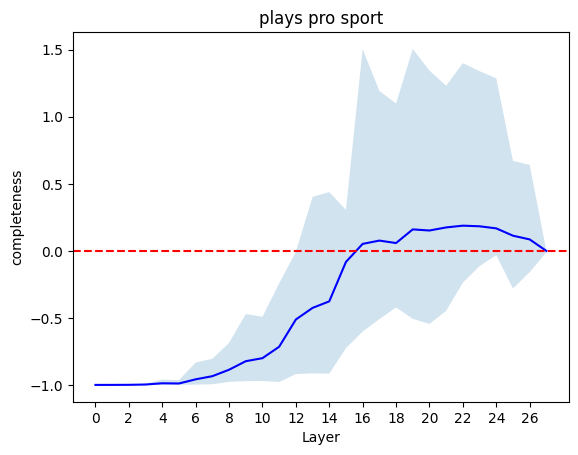

In [6]:
plot_c_measure(cur_relation['layer_completeness'], measure="completeness", title=relation_name).show()

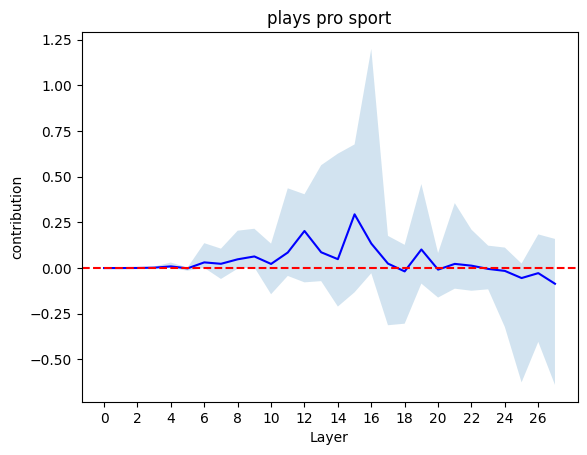

In [7]:
plot_c_measure(cur_relation['layer_contributions'], measure="contribution", title=relation_name).show()

In [9]:
faithfulness_result = {
    layer: faith["recall_lre_if_lm_correct"]
    for layer, faith in cur_relation["faithfulness"].items()
}

## Finalizing `select_layer` Algo

In [39]:
from src import data

dataset = data.load_dataset()
cur_relation =[d for d in dataset if d.name == "country capital city"][0]
print(cur_relation)
len(cur_relation.samples)

Relation(name='country capital city', prompt_templates=['The capital city of {} is', 'The political capital of {} is', 'The seat of government for {} is', 'The government of {} is centered in'], samples=[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='Canada', object='Ottawa'), RelationSample(subject='Mexico', object='Mexico City'), RelationSample(subject='Brazil', object='Bras\\u00edlia'), RelationSample(subject='Argentina', object='Buenos Aires'), RelationSample(subject='Chile', object='Santiago'), RelationSample(subject='Peru', object='Lima'), RelationSample(subject='Colombia', object='Bogot\\u00e1'), RelationSample(subject='Venezuela', object='Caracas'), RelationSample(subject='Spain', object='Madrid'), RelationSample(subject='France', object='Paris'), RelationSample(subject='Germany', object='Berlin'), RelationSample(subject='Italy', object='Rome'), RelationSample(subject='Russia', object='Moscow'), RelationSample(subject='China', object=

24

In [71]:
layer_selection_samples = select_subset_from_relation(cur_relation, 20)
layer_selection_samples.samples

[RelationSample(subject='Australia', object='Canberra'),
 RelationSample(subject='United States', object='Washington D.C.'),
 RelationSample(subject='Saudi Arabia', object='Riyadh'),
 RelationSample(subject='Brazil', object='Bras\\u00edlia'),
 RelationSample(subject='Nigeria', object='Abuja'),
 RelationSample(subject='Peru', object='Lima'),
 RelationSample(subject='Turkey', object='Ankara'),
 RelationSample(subject='South Korea', object='Seoul'),
 RelationSample(subject='Chile', object='Santiago'),
 RelationSample(subject='Pakistan', object='Islamabad'),
 RelationSample(subject='Colombia', object='Bogot\\u00e1'),
 RelationSample(subject='France', object='Paris'),
 RelationSample(subject='Egypt', object='Cairo'),
 RelationSample(subject='India', object='New Delhi'),
 RelationSample(subject='Venezuela', object='Caracas'),
 RelationSample(subject='Spain', object='Madrid'),
 RelationSample(subject='China', object='Beijing'),
 RelationSample(subject='Germany', object='Berlin'),
 RelationSam

searching for optimal layer:   0%|          | 0/20 [00:00<?, ?it/s]

(RelationSample(subject='Turkey', object='Ankara'), RelationSample(subject='Venezuela', object='Caracas'))
The capital city of Peru is Lima
The capital city of Brazil is Bras\u00edlia
The capital city of Saudi Arabia is Riyadh
The capital city of {} is


searching for optimal layer:   5%|▌         | 1/20 [00:01<00:33,  1.78s/it]

(RelationSample(subject='Nigeria', object='Abuja'), RelationSample(subject='Venezuela', object='Caracas'))
The capital city of Chile is Santiago
The capital city of Saudi Arabia is Riyadh
The capital city of Russia is Moscow
The capital city of {} is


searching for optimal layer:  10%|█         | 2/20 [00:03<00:32,  1.79s/it]

(RelationSample(subject='Egypt', object='Cairo'), RelationSample(subject='Germany', object='Berlin'))
The capital city of Brazil is Bras\u00edlia
The capital city of Colombia is Bogot\u00e1
The capital city of Australia is Canberra
The capital city of {} is


searching for optimal layer:  15%|█▌        | 3/20 [00:05<00:29,  1.74s/it]

(RelationSample(subject='Australia', object='Canberra'), RelationSample(subject='Argentina', object='Buenos Aires'))
The capital city of Venezuela is Caracas
The capital city of China is Beijing
The capital city of Pakistan is Islamabad
The capital city of {} is


searching for optimal layer:  20%|██        | 4/20 [00:06<00:27,  1.72s/it]

(RelationSample(subject='Peru', object='Lima'), RelationSample(subject='India', object='New Delhi'))
The capital city of Turkey is Ankara
The capital city of Pakistan is Islamabad
The capital city of China is Beijing
The capital city of {} is


searching for optimal layer:  25%|██▌       | 5/20 [00:08<00:25,  1.71s/it]

(RelationSample(subject='Colombia', object='Bogot\\u00e1'), RelationSample(subject='Egypt', object='Cairo'))
The capital city of Spain is Madrid
The capital city of Nigeria is Abuja
The capital city of France is Paris
The capital city of {} is


searching for optimal layer:  30%|███       | 6/20 [00:10<00:23,  1.70s/it]

(RelationSample(subject='Australia', object='Canberra'), RelationSample(subject='Germany', object='Berlin'))
The capital city of India is New Delhi
The capital city of Pakistan is Islamabad
The capital city of Venezuela is Caracas
The capital city of {} is


searching for optimal layer:  35%|███▌      | 7/20 [00:12<00:22,  1.73s/it]

(RelationSample(subject='Turkey', object='Ankara'), RelationSample(subject='Russia', object='Moscow'))
The capital city of India is New Delhi
The capital city of Colombia is Bogot\u00e1
The capital city of Saudi Arabia is Riyadh
The capital city of {} is


searching for optimal layer:  40%|████      | 8/20 [00:13<00:20,  1.71s/it]

(RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='Peru', object='Lima'))
The capital city of France is Paris
The capital city of South Korea is Seoul
The capital city of Turkey is Ankara
The capital city of {} is


searching for optimal layer:  45%|████▌     | 9/20 [00:15<00:18,  1.70s/it]

(RelationSample(subject='Egypt', object='Cairo'), RelationSample(subject='Russia', object='Moscow'))
The capital city of France is Paris
The capital city of Saudi Arabia is Riyadh
The capital city of Australia is Canberra
The capital city of {} is


searching for optimal layer:  50%|█████     | 10/20 [00:17<00:16,  1.69s/it]

(RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='India', object='New Delhi'))
The capital city of Pakistan is Islamabad
The capital city of South Korea is Seoul
The capital city of France is Paris
The capital city of {} is


searching for optimal layer:  55%|█████▌    | 11/20 [00:18<00:15,  1.73s/it]

(RelationSample(subject='Venezuela', object='Caracas'), RelationSample(subject='Germany', object='Berlin'))
The capital city of Spain is Madrid
The capital city of South Korea is Seoul
The capital city of Colombia is Bogot\u00e1
The capital city of {} is


searching for optimal layer:  60%|██████    | 12/20 [00:20<00:13,  1.71s/it]

(RelationSample(subject='Australia', object='Canberra'), RelationSample(subject='Russia', object='Moscow'))
The capital city of India is New Delhi
The capital city of Germany is Berlin
The capital city of Nigeria is Abuja
The capital city of {} is


searching for optimal layer:  65%|██████▌   | 13/20 [00:22<00:12,  1.74s/it]

(RelationSample(subject='Nigeria', object='Abuja'), RelationSample(subject='Germany', object='Berlin'))
The capital city of South Korea is Seoul
The capital city of Brazil is Bras\u00edlia
The capital city of Peru is Lima
The capital city of {} is


searching for optimal layer:  70%|███████   | 14/20 [00:24<00:10,  1.72s/it]

(RelationSample(subject='Chile', object='Santiago'), RelationSample(subject='Pakistan', object='Islamabad'))
The capital city of Peru is Lima
The capital city of Australia is Canberra
The capital city of France is Paris
The capital city of {} is


searching for optimal layer:  75%|███████▌  | 15/20 [00:25<00:08,  1.71s/it]

(RelationSample(subject='Spain', object='Madrid'), RelationSample(subject='Germany', object='Berlin'))
The capital city of Saudi Arabia is Riyadh
The capital city of Russia is Moscow
The capital city of Peru is Lima
The capital city of {} is


searching for optimal layer:  80%|████████  | 16/20 [00:27<00:06,  1.71s/it]

(RelationSample(subject='Brazil', object='Bras\\u00edlia'), RelationSample(subject='Pakistan', object='Islamabad'))
The capital city of Russia is Moscow
The capital city of France is Paris
The capital city of China is Beijing
The capital city of {} is


searching for optimal layer:  85%|████████▌ | 17/20 [00:29<00:05,  1.71s/it]

(RelationSample(subject='Chile', object='Santiago'), RelationSample(subject='Spain', object='Madrid'))
The capital city of Turkey is Ankara
The capital city of Russia is Moscow
The capital city of Peru is Lima
The capital city of {} is


searching for optimal layer:  90%|█████████ | 18/20 [00:30<00:03,  1.73s/it]

(RelationSample(subject='China', object='Beijing'), RelationSample(subject='Argentina', object='Buenos Aires'))
The capital city of United States is Washington D.C.
The capital city of Nigeria is Abuja
The capital city of Brazil is Bras\u00edlia
The capital city of {} is


searching for optimal layer:  95%|█████████▌| 19/20 [00:32<00:01,  1.72s/it]

(RelationSample(subject='Colombia', object='Bogot\\u00e1'), RelationSample(subject='France', object='Paris'))
The capital city of Pakistan is Islamabad
The capital city of Turkey is Ankara
The capital city of Australia is Canberra
The capital city of {} is


searching for optimal layer: 100%|██████████| 20/20 [00:34<00:00,  1.72s/it]


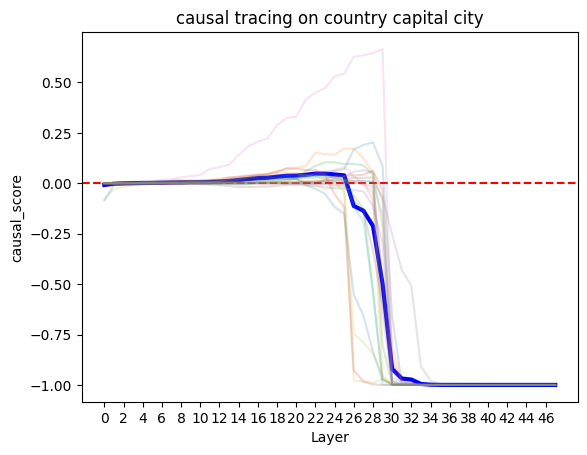

/home/local_arnab/Codes/relations/notebooks/../src/select_hparams.py:126: RuntimeWarning: Mean of empty slice.
  kneedle = KneeLocator(


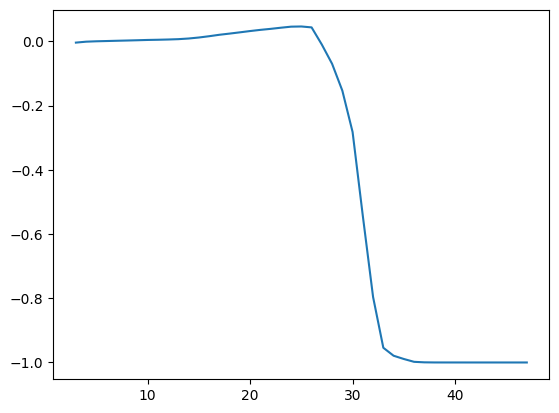

Knee: 26, Elbow: 26


26

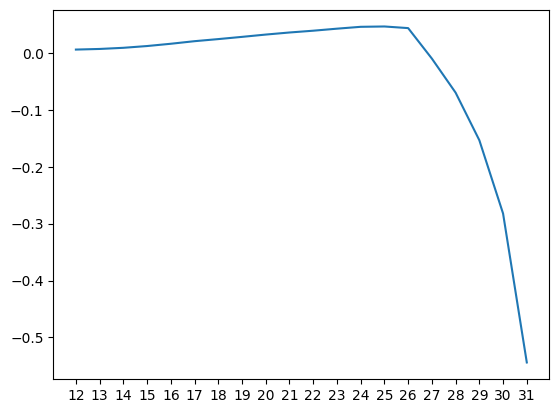

In [78]:
from src.select_hparams import select_layer
select_layer(
    mt = mt,
    training_data = layer_selection_samples,
    verbose=True
)

In [49]:
from h_param_sweep.layer_sweep import filter_by_model_knowledge, choose_sample_pairs
from src.functional import make_prompt
from src.select_hparams import causal_tracing

relation = cur_relation
layer_names = models.determine_layer_paths(mt)

icl_indices = np.random.choice(range(len(relation.samples)), 3, replace=False)
icl_samples = [relation.samples[i] for i in icl_indices]

icl_prompt = make_prompt(
    prompt_template=relation.prompt_templates[0],
    subject="{}",
    examples=icl_samples,
)

relation_known = filter_by_model_knowledge(
    mt, relation_prompt=icl_prompt, relation_samples=relation.samples
)

test_samples = set(relation_known) - set(icl_samples)
causal_tracing_results: dict = {layer: [] for layer in layer_names}

for run in tqdm(range(20)):
    sample_pair = choose_sample_pairs(list(test_samples))
    cur_result = causal_tracing(
        mt,
        prompt_template=icl_prompt,
        subject_original=sample_pair[0].subject,
        subject_corruption=sample_pair[1].subject,
    )

    for layer in layer_names:
        causal_tracing_results[layer].append(cur_result[layer])

  0%|          | 0/20 [00:00<?, ?it/s]

Exception ignored in: <function tqdm.__del__ at 0x7f1da0119ea0>
Traceback (most recent call last):
  File "/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/tqdm/std.py", line 1145, in __del__
    self.close()
  File "/home/local_arnab/miniconda3/envs/relations/lib/python3.10/site-packages/tqdm/notebook.py", line 286, in close
    self.disp(bar_style='success', check_delay=False)
AttributeError: 'tqdm' object has no attribute 'disp'


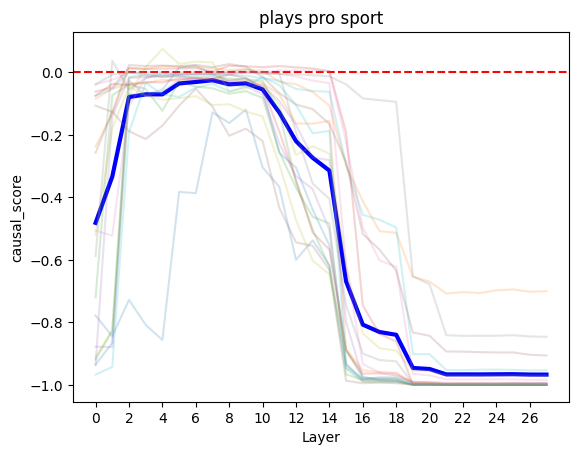

In [51]:
plot_layer_wise_causal_tracing(causal_tracing_results, title = relation_name).show()

## Bias Scale Sweep

In [105]:
results_dir = "../results/layer_sweep/gptj"
sweep_relations = os.listdir(results_dir)

In [107]:
recall_results_collection = {}
bias_scales = None

for relation_result in sweep_relations:
    with open(f"{results_dir}/{relation_result}") as f:
        sweep_results = json.load(f)
        # print(f"{relation_result.split('.')[0]}: {sweep_results['optimal_layer']}")
        # sweep_results = sweep_results['results']
        sweep_results = sweep_results['faithfulness']

        result = np.array([
            sweep_results[bias_scale_factor]['recall_lre_if_lm_correct']
            for bias_scale_factor in sweep_results.keys()
        ])
        if(bias_scales is None):
            bias_scales = list(sweep_results.keys())
            recall_results_collection = {bias_scale_factor: [] for bias_scale_factor in sweep_results.keys()}

        for bias_scale_factor in sweep_results.keys():
            recall_results_collection[bias_scale_factor].append(
                sweep_results[bias_scale_factor]['recall_lre_if_lm_correct']
            )

In [108]:
recall_results_collection.keys()

dict_keys(['transformer.h.0', 'transformer.h.1', 'transformer.h.2', 'transformer.h.3', 'transformer.h.4', 'transformer.h.5', 'transformer.h.6', 'transformer.h.7', 'transformer.h.8', 'transformer.h.9', 'transformer.h.10', 'transformer.h.11', 'transformer.h.12', 'transformer.h.13', 'transformer.h.14', 'transformer.h.15', 'transformer.h.16', 'transformer.h.17', 'transformer.h.18', 'transformer.h.19', 'transformer.h.20', 'transformer.h.21', 'transformer.h.22', 'transformer.h.23', 'transformer.h.24', 'transformer.h.25', 'transformer.h.26', 'transformer.h.27'])

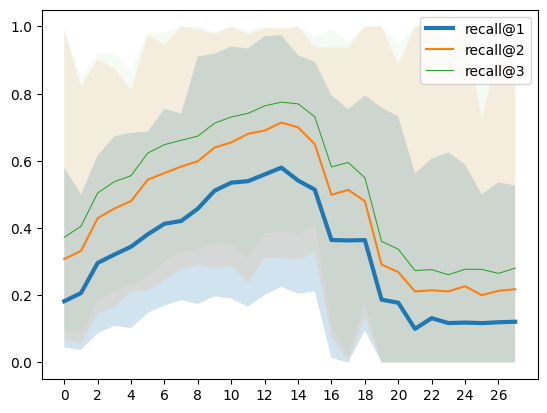

In [114]:
for bias_scale_factor in recall_results_collection.keys():
    recall_results_collection[bias_scale_factor] = np.array(recall_results_collection[bias_scale_factor])
    # print(bias_scale_factor, recall_results_collection[bias_scale_factor].shape)

recall_upto = 3
linewidth = 3
alpha = 0.2
for recall_at in range(recall_upto):
    mean = np.array([
        recall_results_collection[bias_scale_factor][:, recall_at].mean()
        for bias_scale_factor in recall_results_collection.keys()
    ])
    low = np.array([
        recall_results_collection[bias_scale_factor][:, recall_at].min()
        for bias_scale_factor in recall_results_collection.keys()
    ])
    high = np.array([
        recall_results_collection[bias_scale_factor][:, recall_at].max()
        for bias_scale_factor in recall_results_collection.keys()
    ])

    plt.plot(mean, linewidth=linewidth, label=f"recall@{recall_at + 1}")
    plt.fill_between(
        range(len(mean)),
        low,    # lower bound
        high,   # upper bound
        alpha=alpha
    )
    linewidth /= 2
    alpha /= 2
# plt.xticks(
#     range(len(recall_results_collection.keys())), 
#     list(recall_results_collection.keys())
# )

plt.xticks(range(0, len(recall_results_collection.keys()), 2))

plt.legend()
plt.show()

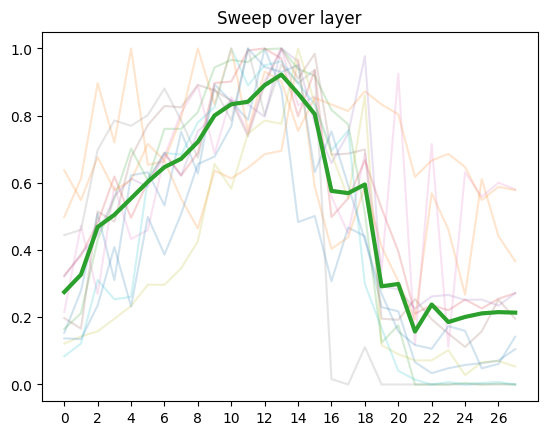

In [117]:
recall_at = 0
one_key = list(recall_results_collection.keys())[0]


all_results = []
for r in range(recall_results_collection[one_key].shape[0]):
    r_result = np.array([
        recall_results_collection[bias_scale_factor][r, recall_at]
        for bias_scale_factor in recall_results_collection.keys()
    ])
    r_result = r_result/r_result.max()
    plt.plot(
        r_result,
        alpha=0.2
    )
    all_results.append(r_result)

all_results = np.array(all_results)
plt.plot(all_results.mean(axis = 0), linewidth=3)
# plt.xticks(range(len(recall_results_collection.keys())), list(recall_results_collection.keys()))

plt.xticks(range(0, len(recall_results_collection.keys()), 2))
plt.title("Sweep over layer")
plt.show()

## Rank Sweep

In [18]:
from src.benchmarks import causality, faithfulness
from h_param_sweep.utils import select_subset_from_relation

In [19]:
max_samples = 20
###################################################
FILTER_RELATIONS: list = [
    # "country capital city",
    # "occupation",
    "person superhero name",
    "plays pro sport",
    "landmark in country",
    "outside color of fruits and vegetables",
    # "work location",
    # "task done by person NEEDS REVISION",
    # "word comparative",
    # "word past tense",
    # "name gender",
    # "name religion",
]
###################################################

In [20]:
dataset = data.load_dataset()
dataset = data.RelationDataset(
    relations=[
        select_subset_from_relation(
            relation = r,
            n = max_samples)  
        for r in dataset.relations if r.name in FILTER_RELATIONS]
)
for d in dataset.relations:
    print(f"{d.name} : {len(d.samples)}")

landmark in country : 20
outside color of fruits and vegetables : 15
plays pro sport : 20
person superhero name : 20


In [46]:
from src.benchmarks import causality, faithfulness

In [47]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=13,
    bias_scale_factor=0.4,       # so that the bias doesn't knock out the prediction too much in the direction of training examples
    rank = 150
) 

In [62]:
faith_result = faithfulness(
    estimator = mean_estimator,
    dataset = dataset,
    n_train = 3,
    n_trials = 5,
    k = 3,
    results_dir="../results/faithfulness",
)

faithfulness:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [48]:
from src.editors import LowRankPInvEditor, LowRankPInvEmbedEditor, EmbedBaselineEditor
editor = LowRankPInvEditor(
    lre = mean_estimator,
    rank = 150
)

In [49]:
causality_results = causality(
    estimator= mean_estimator,
    editor_type = LowRankPInvEditor,
    dataset = dataset,
    rank = 150
)

causality:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [30]:
prompts = [
    "The capital of France is",
    "The capital of Germany is",
]

tokenized = mt.tokenizer(prompts, return_tensors="pt", padding=True).to(mt.model.device)

In [36]:
tokenized.input_ids.expand(tokenized.input_ids.shape[0], -1)

tensor([[ 464, 3139,  286, 4881,  318],
        [ 464, 3139,  286, 4486,  318]], device='cuda:0')

In [17]:
causality_results.metrics.__dict__

{'efficacy_mean': 0.20512820780277252, 'efficacy_std': 0.4039623737335205}

In [50]:
causality_results_embed = causality(
    estimator= mean_estimator,
    editor_type = LowRankPInvEmbedEditor,
    dataset = dataset,
    rank = 150
)

causality:   0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [20]:
causality_results_embed.metrics.__dict__

{'efficacy_mean': 0.5167223811149597, 'efficacy_std': 0.4999293386936188}

In [51]:
causality_results_base = causality(
    estimator= mean_estimator,
    editor_type = EmbedBaselineEditor,
    dataset = dataset,
)

causality:   0%|          | 0/4 [00:00<?, ?it/s]

In [24]:
causality_results_base.metrics.__dict__

{'efficacy_mean': 0.12949039041996002, 'efficacy_std': 0.3358822464942932}

In [25]:
dataset = data.load_dataset()
cur_relation =[d for d in dataset if d.name == "country capital city"][0]
print(cur_relation)
# capital_cities.__dict__.keys()
len(cur_relation.samples)

Relation(name='country capital city', prompt_templates=['The capital city of {} is', 'The political capital of {} is', 'The seat of government for {} is', 'The government of {} is centered in'], samples=[RelationSample(subject='United States', object='Washington D.C.'), RelationSample(subject='Canada', object='Ottawa'), RelationSample(subject='Mexico', object='Mexico City'), RelationSample(subject='Brazil', object='Bras\\u00edlia'), RelationSample(subject='Argentina', object='Buenos Aires'), RelationSample(subject='Chile', object='Santiago'), RelationSample(subject='Peru', object='Lima'), RelationSample(subject='Colombia', object='Bogot\\u00e1'), RelationSample(subject='Venezuela', object='Caracas'), RelationSample(subject='Spain', object='Madrid'), RelationSample(subject='France', object='Paris'), RelationSample(subject='Germany', object='Berlin'), RelationSample(subject='Italy', object='Rome'), RelationSample(subject='Russia', object='Moscow'), RelationSample(subject='China', object=

24

In [26]:
indices = np.random.choice(range(len(cur_relation.samples)), 3, replace=False)
samples = [cur_relation.samples[i] for i in indices]

training_samples = copy.deepcopy(cur_relation.__dict__)
training_samples["samples"] = samples
training_samples = data.Relation(**training_samples)

training_samples.samples

[RelationSample(subject='Brazil', object='Bras\\u00edlia'),
 RelationSample(subject='Spain', object='Madrid'),
 RelationSample(subject='Saudi Arabia', object='Riyadh')]

In [46]:
from src.operators import JacobianIclMeanEstimator

mean_estimator = JacobianIclMeanEstimator(
    mt=mt,
    h_layer=12,
    bias_scale_factor=0.4       # so that the bias doesn't knock out the prediction too much in the direction of training examples
) 

operator = mean_estimator(training_samples)
operator("United States", k = 10).predictions

[PredictedToken(token=' Washington', prob=0.19310110807418823),
 PredictedToken(token='\n', prob=0.17582055926322937),
 PredictedToken(token=' ', prob=0.1412757784128189),
 PredictedToken(token=' the', prob=0.031277578324079514),
 PredictedToken(token='...', prob=0.017682738602161407),
 PredictedToken(token=' Madrid', prob=0.016100317239761353),
 PredictedToken(token=' San', prob=0.015007143840193748),
 PredictedToken(token=' (', prob=0.012836292386054993),
 PredictedToken(token=' Bras', prob=0.012736398726701736),
 PredictedToken(token=' R', prob=0.012248474173247814)]

In [47]:
from h_param_sweep.utils import select_subset_from_relation

layer_training = select_subset_from_relation(
    relation = cur_relation,
    n = 20
)

searching for optimal layer: 100%|██████████| 20/20 [00:29<00:00,  1.47s/it]

Knee: 13, Elbow: 13


13

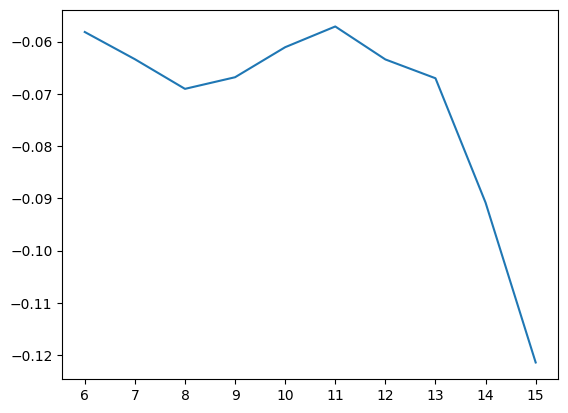

In [48]:
from src.select_hparams import select_layer
select_layer(
    mt = mt,
    training_data = layer_training,
    verbose=True
)

In [49]:
operator.__dict__.keys()

dict_keys(['mt', 'weight', 'bias', 'h_layer', 'z_layer', 'prompt_template', 'metadata'])

In [57]:
from src.operators import LinearRelationOperator
from src.select_hparams import low_rank_approximation

In [58]:
weight_lr = low_rank_approximation(
    weight = operator.weight,
    rank = 150
) 

In [59]:
operator_dict = {k: v for k, v in operator.__dict__.items() if k != "weight"}
operator_dict["weight"] = weight_lr
operator_lr = LinearRelationOperator(**operator_dict)

In [60]:
torch.dist(operator.weight, operator_lr.weight)

tensor(8.6172, device='cuda:0', dtype=torch.float16)

In [64]:
from src.functional import low_rank_approx

weight_lr2 = low_rank_approx(matrix = operator.weight, rank = 150)

In [65]:
torch.dist(weight_lr, weight_lr2)

tensor(0.0001, device='cuda:0', dtype=torch.float16)